In [34]:
# Import the dependencies
import numpy as np
from scipy.linalg import toeplitz, cholesky, sqrtm, inv
# import scipy.linalg as la
from scipy import signal
from scipy.integrate import odeint
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
print("Imports done")


Imports done


In [35]:
#script 1 basic AI
import numpy as np
from statistics import mean, variance, pstdev
# Setting up the time data:
dt = 0.005; # integration step, average neuron resets 200 times per second
T = 450 + dt; # maximum time considered
t = np.arange(0,T,dt)
N= t.size #Amount of data points



def g_gp(x):

    t0=25
    return t0 -16 / (1 + np.exp(5-x/5))

def dg_gp(x):
    
    return -16/5* np.exp(5-x/5) / (np.exp(5-x/5)+1)**2



#initate arrays
mu_x = np.zeros(N)
e_x = np.zeros(N)
e_y = np.zeros(N)
y =np.zeros(N)
x = np.ones(N)*30


omega_x = np.zeros(N)
omega_y = np.zeros(N)
sigma_x = np.zeros(N)
sigma_y = np.zeros(N)
std = np.zeros(N)


omega_x[0] = 5
omega_y[0] = 5 
mu_v = 30
mu_x[0]= 25
std_noise_x = 0.5
std_noise_y = 0.5

alpha_x = 1
alpha_y = 1

alpha_mux = 1
dmuxvec= [0]

for i in np.arange(0,N-1):
   # x = x + np.random.randn(1)*std_noise
    
    # prior real depth: x == prior: mu_v == 30
    x[i] = mu_v         # + np.random.randn(1)*std_noise_x       #x[i+1]  gebruiken
    y[i] = g_gp(x[i])    + np.random.randn(1)*std_noise_y *np.sin(10*1/N*i)

    sigma_x[i] =  1/omega_x[i]
    sigma_y[i] =  1/omega_y[i]
    
    e_x[i] = mu_x[i] - mu_v    # Mu_x[0] = 25 and mu_v = 30 
    e_y[i] = y[i] - g_gp(mu_x[i]) # x = 30 so y(i) = g(30)

    # hidden stsate update
    dFdmu_x = e_x[i]*omega_x[i] - dg_gp(mu_x[i]) * e_y[i]*omega_y[i]
    dmu_x   = 0 - alpha_mux* dFdmu_x
    mu_x[i+1] = mu_x[i] + dt*dmu_x


    #precision update
    domega_x = alpha_x*(0.5*(1/omega_x[i] - e_x[i]**2))
    domega_y = alpha_y*(0.5*(1/omega_y[i] - e_y[i]**2))
    omega_x[i+1] = omega_x[i] + dt*domega_x
    omega_y[i+1] = omega_y[i] + dt*domega_y

   
    sigma_x[i+1] =1/ omega_x[i+1]
    sigma_y[i+1] =1/ omega_y[i+1]

In [36]:
#script 2 Generalized coordinates
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz, cholesky, sqrtm, inv

# Define time settings
T = 10
dt = 0.005
time = np.arange(0, T, dt)
N  = time.size

x = np.zeros(N)
x_dot = np.zeros(N)
y = np.zeros(N)
y_dot = np.zeros(N)
mu = np.zeros(N)
mu_dot = np.zeros(N)
u = np.zeros(N)


omega_w0 = np.zeros(N)
omega_w1 = np.zeros(N)
omega_z0 = np.zeros(N)
omega_z1 = np.zeros(N)

omega_w0[0] = 1
omega_w1[0] = 1
omega_z0[0] = 1
omega_z1[0] = 1

alpha_mu = 1
alpha_x = 0.05
alpha_y = 0.05


x[0] = 30
mu[0]= 25

D = np.array([[0,1],[0,0]])

# Generative process 
for i in np.arange(0,N-1):

    x_dot[i] = -x[i] + 30   #np.random.randn(1)*0.5
    x[i+1] = x[i] + dt*x_dot[i]

    y[i] = x[i] #+ np.random.randn(1)*0.3
    y_dot[i] = x_dot[i] #+np.random.randn(1)*0.5


    



for i in np.arange(0,N-1):
    
    #use these form gp: xdot = 1
    # dFdmu = np.dot(np.identity(2),np.dot(PI_w,e_x)) - np.dot(np.identity(2),np.dot(PI_z,e_y))
    #e_x = np.array([[mu_dot[i]], [0]]) - np.array([[1],[0]])



    PI_w = np.diag([omega_w0[i],omega_w1[i]])
    PI_z = np.diag([omega_z0[i],omega_z1[i]])

    
    e_x = np.array([[mu_dot[i]], [0]]) - (np.array([[-mu[i]],[-mu_dot[i]]])+np.array([[30],[0]]))
    e_y = np.array([[y[i]],[y_dot[i]]]) - np.array([[mu[i]],[mu_dot[i]]])
    #e_y = np.array([[y[i]],[0]]) - np.array([[mu[i]],[mu_dot[i]]])

    
    dFdmu = np.dot(np.array([[1,1],[0,1]]),np.dot(PI_w,e_x)) - np.dot(np.identity(2),np.dot(PI_z,e_y))
    dmu = np.array([[mu_dot[i]], [0]]) - alpha_mu*dFdmu
    
    mu[i+1] = mu[i] + dt*dmu[0]
    mu_dot[i+1] = mu_dot[i] +dt*dmu[1]

  
    #   precision optimization
    dPI_w = alpha_x*0.5*(inv(PI_w) - np.diag(e_x.flatten())**2)
    dPI_z = alpha_y*0.5*(inv(PI_z) - np.diag(e_y.flatten())**2)
    PI_w = PI_w + dt*dPI_w
    PI_z = PI_z + dt*dPI_z

    omega_w0[i+1] = PI_w[0,0]
    omega_w1[i+1] = PI_w[1,1]
    omega_z0[i+1] = PI_z[0,0]
    omega_z1[i+1] = PI_z[1,1]

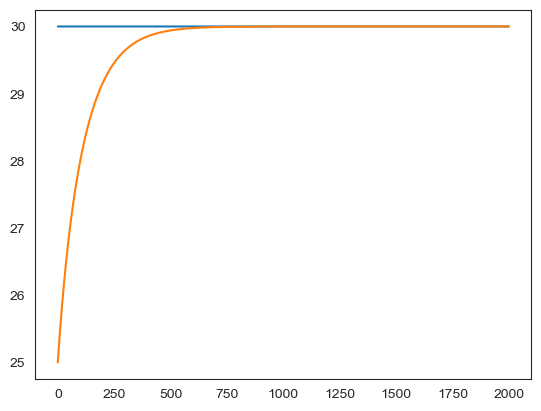

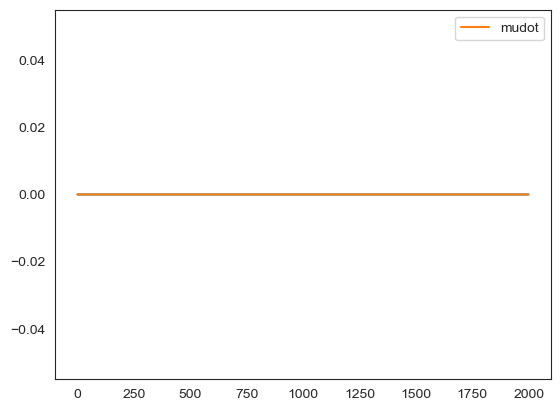

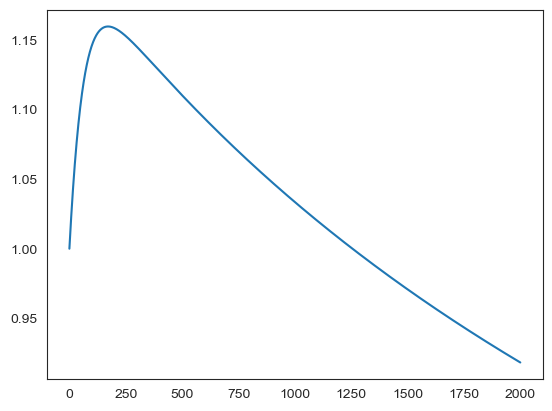

In [37]:
#plot2
plt.figure()
plt.plot(x)
plt.plot(mu, label = "mu")
plt.legend
# plt.plot(mu_dot)

plt.figure()
plt.plot(x_dot)
plt.plot(mu_dot, label = "mudot")
plt.legend()

# plt.figure()
# plt.plot(mu)

plt.figure()
plt.plot(1/omega_z0)

In [54]:
#script 3  Generalized coordinates with Action
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz, cholesky, sqrtm, inv

# Define time settings
T = 10
dt = 0.005
time = np.arange(0, T, dt)
N  = time.size

x = np.zeros(N)
x_dot = np.zeros(N)
y = np.zeros(N)
y_dot = np.zeros(N)
mu = np.zeros(N)
mu_dot = np.zeros(N)
u = np.zeros(N)

omega_w0 = np.zeros(N)
omega_w1 = np.zeros(N)
omega_z0 = np.zeros(N)
omega_z1 = np.zeros(N)

omega_w0[0] = 5
omega_w1[0] = 5
omega_z0[0] = 5
omega_z1[0] = 5

alpha_mu = 1
alpha_u =1
alpha_w =0.1
alpha_z = 0.1

x[0] = 30
mu[0] = 25
mu_v = 25

mu_dot[0] = - mu[0] + mu_v

D = np.array([[0,1],[0,0]])



for i in np.arange(0,N-1):
    
    #generative process(in geval van wél aciton)
    x_dot[i] = u[i]  #np.random.randn(1)*0.5
    x[i+1] = x[i] + dt*x_dot[i]

    y[i] = x[i] #+ np.random.randn(1)*0.3
    y_dot[i] = x_dot[i] #+np.random.randn(1)*0.5
 
    
    
    #Set precision matrices for iteration
    PI_w = np.diag([omega_w0[i],omega_w1[i]])
    PI_z = np.diag([omega_z0[i],omega_z1[i]])

    # PI_w = np.diag([1,1])
    # PI_z = np.diag([0.1,0.1])
    
    #prediction errors
    e_x = np.array([[mu_dot[i]], [0]]) - (np.array([[-mu[i]],[-mu_dot[i]]])+np.array([[mu_v],[0]]))
    e_y = np.array([[y[i]],[y_dot[i]]]) - np.array([[mu[i]],[mu_dot[i]]])
    # e_y = np.array([[y[i]],[0]]) - np.array([[mu[i]],[mu_dot[i]]])


    #belief update
    dFdmu = np.dot(np.array([[1,1],[0,1]]),np.dot(PI_w,e_x)) - np.dot(np.identity(2),np.dot(PI_z,e_y))
    dmu = np.array([[mu_dot[i]], [0]]) - alpha_mu*dFdmu
    
    mu[i+1] = mu[i] + dt*dmu[0]
    mu_dot[i+1] = mu_dot[i] +dt*dmu[1]

    #action
    u_dot = -np.array([0,1]).dot(PI_z).dot(e_y)
    u[i+1] = u[i] + dt*u_dot

    #   precision updating
    dPI_w = alpha_w*0.5*(inv(PI_w) - np.diag(e_x.flatten())**2)
    dPI_z = alpha_z*0.5*(inv(PI_z) - np.diag(e_y.flatten())**2)
    PI_w = PI_w + dt*dPI_w
    PI_z = PI_z + dt*dPI_z

    omega_w0[i+1] = PI_w[0,0]
    omega_w1[i+1] = PI_w[1,1]
    omega_z0[i+1] = PI_z[0,0]
    omega_z1[i+1] = PI_z[1,1]




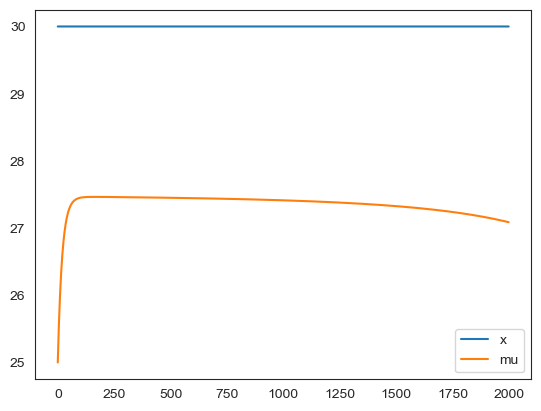

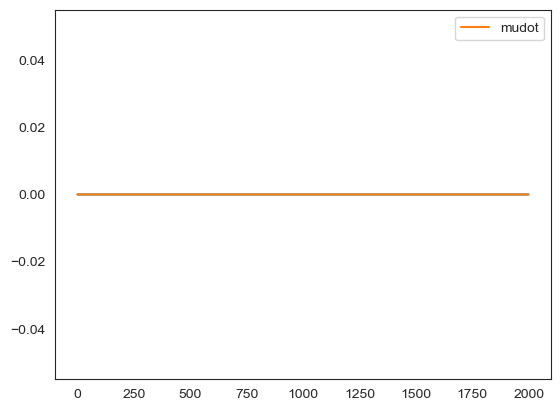

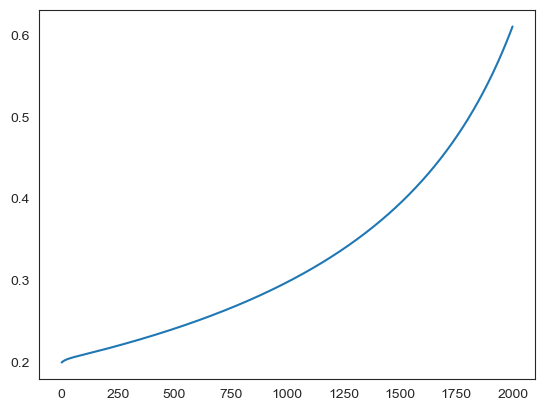

In [55]:


plt.figure()
plt.plot(x, label = "x")
plt.plot(mu, label = "mu")
plt.legend()
# plt.plot(mu_dot)

plt.figure()
plt.plot(x_dot)
plt.plot(mu_dot, label = "mudot")
plt.legend()

# plt.figure()
# plt.plot(mu)

plt.figure()
plt.plot(1/omega_z0)


In [41]:
print(1/omega_z0[-1])


0.29142361729211386
